In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
path = 'nomination_stability_exp.csv'
stab_info = pd.read_csv(path)
stab_info.head()

,name,protospacer,nomination_count,seed
0,spCas9,AAGGGCTAATTCACTCCCAA,73,0
1,spCas9,GCTAATTCACTCCCAACGAA,2,0
2,spCas9,CTAATTCACTCCCAACGAAG,2,0
3,spCas9,ATCTACCACACACAAGGCTA,134,0
4,spCas9,CTACTTCCCTGATTAGCAGA,3,0


In [3]:
from scipy.stats import rankdata

def rank_linker(ser):
    print(len(ser))
    return rankdata(-ser)


stab_info['rank'] = stab_info.groupby(['name', 'seed'])['nomination_count'].transform(rank_linker)
stab_info.head()

217447
217851
218369
217629
218495
48377
48209
48513
48311
48619
541761
540824
542972
541169
544553


,name,protospacer,nomination_count,seed,rank
0,spCas9,AAGGGCTAATTCACTCCCAA,73,0,5721.5
1,spCas9,GCTAATTCACTCCCAACGAA,2,0,134509.0
2,spCas9,CTAATTCACTCCCAACGAAG,2,0,134509.0
3,spCas9,ATCTACCACACACAAGGCTA,134,0,3290.5
4,spCas9,CTACTTCCCTGATTAGCAGA,3,0,90901.0


In [4]:
nom_piv_df = pd.pivot_table(stab_info.query('rank < 20_000'),
                            index = ['name', 'protospacer'],
                            values = 'nomination_count',
                            aggfunc = ['mean', 'std', 'count']).droplevel(axis=1, level = 1)

nom_piv_df.head()

mean       std  count
name          protospacer                                
LbCas12a_Cpf1 AAAAAAGTGAATATACTTTC  10.6  1.140175      5
              AAAAAAGTGCATATTCTTTC  16.8  1.788854      5
              AAAAAATACAGAATGAAACA   6.8  0.836660      5
              AAAAAATACAGGATGAAACA   7.6  1.140175      5
              AAAAAATATAAACTAAAACA   7.2  0.836660      5

In [5]:
nom_piv_df.groupby(level='name')['std'].mean()

name
LbCas12a_Cpf1    1.715702
saCas9           0.804452
spCas9           3.030748
Name: std, dtype: float64

In [9]:
consistency_counts = nom_piv_df.reset_index().groupby('name')['count'].value_counts()
consistency_counts = (consistency_counts/consistency_counts.groupby(level='name').sum())*100
consistency_counts.name = 'Percent'
consistency_counts = consistency_counts.reset_index()

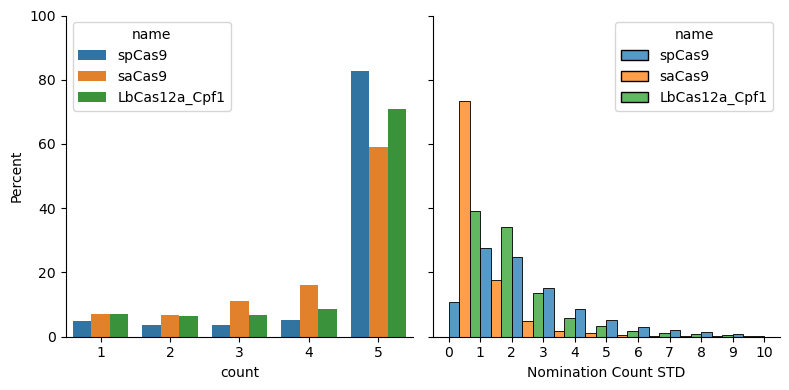

In [20]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

cas_order = ['spCas9', 'saCas9', 'LbCas12a_Cpf1']
sns.barplot(data = consistency_counts,
                  x = 'count', 
                  hue = 'name', 
            hue_order = cas_order,
                  y = 'Percent',
            ax=left_ax)

left_ax.set_ylim(0, 100)

#left_ax.set_xticks(np.arange(0.5, 5.5, 1));
#left_ax.set_xticklabels(int(t) for t in  np.arange(1.4, 6.4, 1))
#left_ax.set_xlabel('Nominated')
#left_ax.set_xlim(0.0, 5.5)

sns.despine(ax=left_ax)


sns.histplot(data = nom_piv_df.reset_index(),
                  x = 'std', 
                  hue = 'name', hue_order = cas_order,
                  bins = np.arange(0, 11, 1),
                  stat = 'percent',
                  multiple = 'dodge',
                  #element = 'step',
                  common_norm=False,
                  fill = True, ax=right_ax, legend='upper right')

right_ax.set_ylim(0, 100)

right_ax.set_xticks(range(11));
right_ax.set_xlabel('Nomination Count STD')

sns.despine(ax=right_ax)

fig.tight_layout()
fig.savefig('nomiation_stability.png', dpi=300)

In [8]:
hit_rate_df = pd.read_csv('validation_stability_exp.csv')
hit_rate_df.head()

,name,protospacer,validation_hit_rate,seed
0,spCas9,AAAGGTGAAGGGGCAGTAGT,0.000000,0
1,spCas9,AGCAGATGATACAGTATTAG,0.027406,0
2,spCas9,GGGATTGGGGGGTACAGTGC,0.983957,0
3,spCas9,GGGGATTGGGGGGTACAGTG,0.002005,0
4,spCas9,GGATTGGGGGGTACAGTGCA,0.910428,0


In [9]:
val_piv = pd.pivot_table(hit_rate_df,
                         index = ['name', 'protospacer'],
                         values = 'validation_hit_rate',
                         aggfunc = 'mean').reset_index()
val_piv.head()

,name,protospacer,validation_hit_rate
0,LbCas12a_Cpf1,AAAAAAGTGAATATACTTTC,0.000267
1,LbCas12a_Cpf1,AAAAAAGTGCATATTCCTTC,0.000000
2,LbCas12a_Cpf1,AAAAAAGTGCATATTCTTTC,0.000000
3,LbCas12a_Cpf1,AAAAAATACAGAATGAAACA,0.000000
4,LbCas12a_Cpf1,AAAAAATACAGGATGAAACA,0.000000


In [10]:
mdf = pd.merge(hit_rate_df, val_piv,
               on = ['name', 'protospacer'],
               suffixes=['_seed', '_mean'])
mdf['delta'] = (mdf['validation_hit_rate_mean']-mdf['validation_hit_rate_seed'])
mdf['under_estimate'] = mdf['delta']>0.01
mdf['over_estimate'] = mdf['delta']<-0.01
mdf['good_estimate'] = mdf['delta'].abs()<0.01

mdf.head()

,name,protospacer,validation_hit_rate_seed,seed,validation_hit_rate_mean,delta,under_estimate,over_estimate,good_estimate
0,spCas9,AAAGGTGAAGGGGCAGTAGT,0.0,0,0.0,0.0,False,False,True
1,spCas9,AAAGGTGAAGGGGCAGTAGT,0.0,1,0.0,0.0,False,False,True
2,spCas9,AAAGGTGAAGGGGCAGTAGT,0.0,2,0.0,0.0,False,False,True
3,spCas9,AAAGGTGAAGGGGCAGTAGT,0.0,3,0.0,0.0,False,False,True
4,spCas9,AAAGGTGAAGGGGCAGTAGT,0.0,4,0.0,0.0,False,False,True


In [11]:
estimate_probs = mdf.groupby('name')[['good_estimate', 'under_estimate', 'over_estimate']].mean()*100
estimate_probs.to_excel('hit_rate_estimates.xlsx')
estimate_probs

,good_estimate,under_estimate,over_estimate
name,,,
LbCas12a_Cpf1,99.606,0.138,0.256
saCas9,99.899,0.027,0.074
spCas9,99.018,0.401,0.581


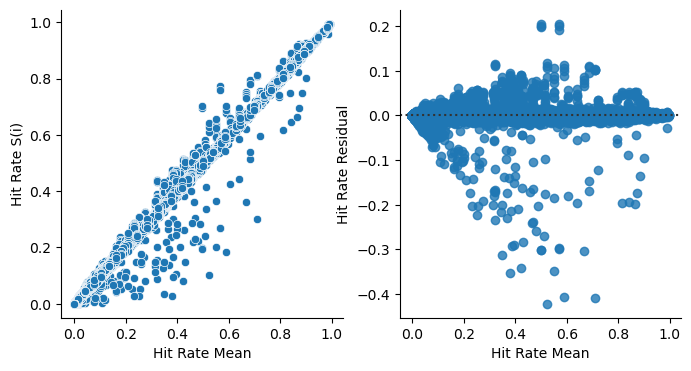

In [12]:
fig, (reg_ax, resid_ax) =  plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(data = mdf,
            x = 'validation_hit_rate_mean',
            y = 'validation_hit_rate_seed',
            ax = reg_ax)
reg_ax.set_ylabel('Hit Rate S(i)')
reg_ax.set_xlabel('Hit Rate Mean')
sns.despine(ax=reg_ax)


sns.residplot(data = mdf,
              x = 'validation_hit_rate_mean',
              y = 'validation_hit_rate_seed',
              ax = resid_ax)

resid_ax.set_ylabel('Hit Rate Residual')
resid_ax.set_xlabel('Hit Rate Mean')
sns.despine(ax=resid_ax)
fig.savefig('validation_stability.png', dpi=300)

In [26]:
from sklearn.metrics import mean_absolute_error

In [17]:
from scipy.stats import linregress

linregress(mdf['validation_hit_rate_mean'], mdf['validation_hit_rate_seed'])

LinregressResult(slope=0.9999999999999999, intercept=0.0, rvalue=0.9986217706835733, pvalue=0.0, stderr=9.595460880921467e-05, intercept_stderr=7.761041774756122e-06)

In [27]:
mean_absolute_error(mdf['validation_hit_rate_mean'], mdf['validation_hit_rate_seed'])

0.0004252085561497314